In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

d:\virtual-env\tfv1\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
dataset = pd.read_csv('D:\\数据集\\Data\Stocks\\hpq.us.txt')
df = dataset.sort_values('Date')

In [3]:
# 计算中间价格
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]
# 将最高价与最低价求均值，得到当天的均价
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])
train_data = train_data.reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)
EMA = 0.0
gamma = 0.1
for ti in range(400):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

all_mid_data = np.concatenate([train_data,test_data],axis=0)

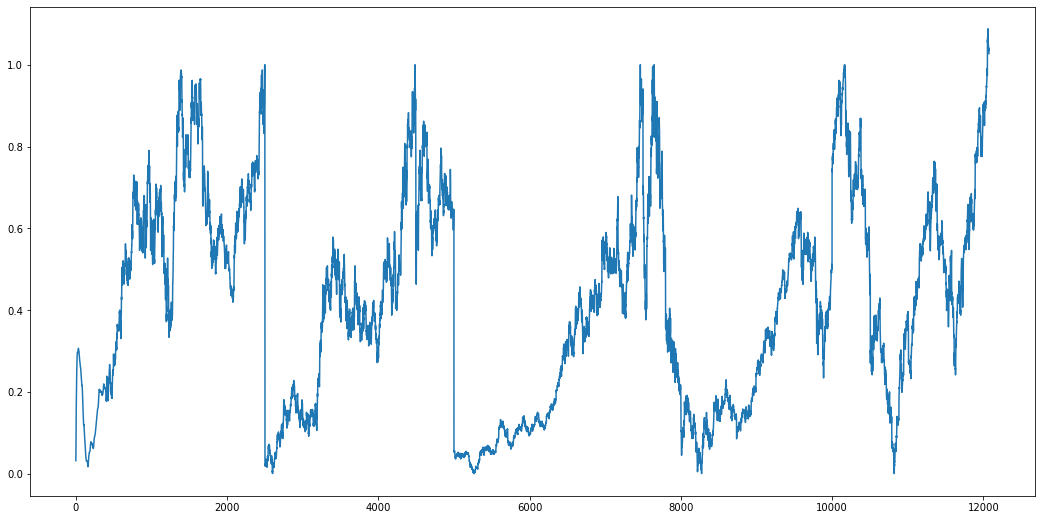

In [4]:
# 归一化后出现4个断点
plt.figure(figsize = (18,9))
plt.plot(all_mid_data)

In [5]:
def trend_label(data,K=2,A=0.5,B=0.5):
    label=[]
    D=data
    S=len(D)
    i=0
    while i<S-1:
        j=0
        UP=0
        DOWN=0
        NO=0
        while j<K:
            cursor =i
            while cursor < S-1 and D[cursor]<=D[cursor+1]:
                cursor+=1
                
            p = cursor
            j+=1
            while cursor < S-1 and D[cursor]>=D[cursor+1]:
                cursor +=1
            t = cursor
            retrace = (D[p]-D[t])/(D[p]-D[i])
            if retrace < A:
                UP+=1
            elif retrace > 1+B:
                DOWN +=1
            else:
                NO +=1
            trend =1
            if UP== K:
                trend=2
            if DOWN == K:
                trend = 0
            while i< cursor:
                label.append(trend)
                i+=1
    label.append(1)
    return label

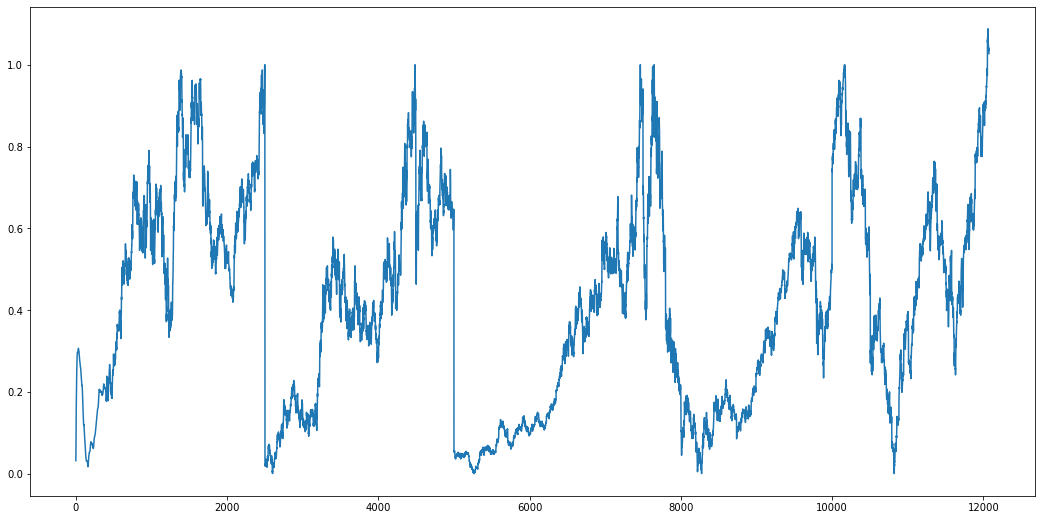

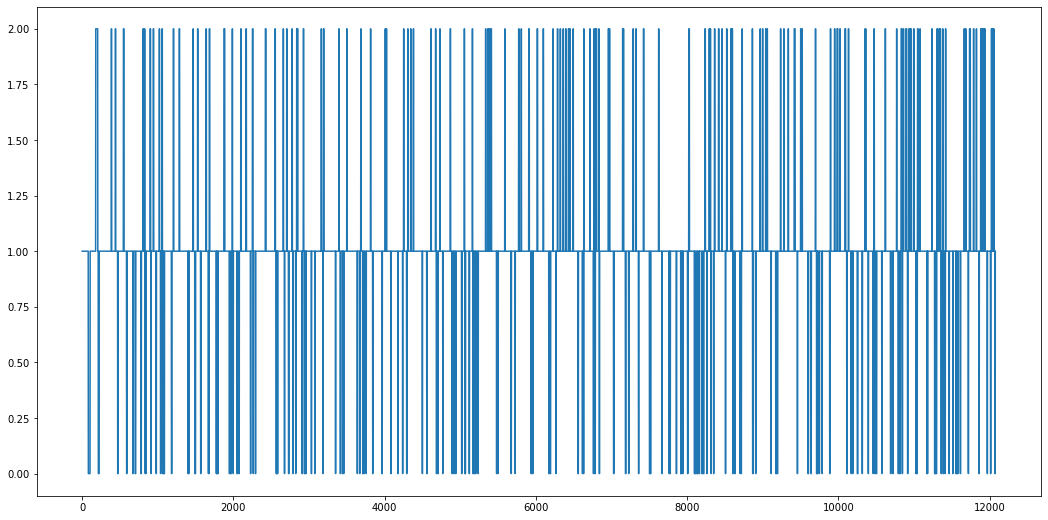

In [6]:
trend_label_array = trend_label(all_mid_data)
plt.figure(figsize = (18,9))
plt.plot(all_mid_data)
plt.show()
plt.figure(figsize = (18,9))
plt.plot(trend_label_array)
plt.show()

In [7]:
data1=np.array([all_mid_data,trend_label_array])

data2=data1.T
print(data2.shape)
print(data2[::5])


(12075, 2)
[[0.03143791 1.        ]
 [0.15261841 1.        ]
 [0.23024741 1.        ]
 ...
 [1.0879207  1.        ]
 [1.03975146 1.        ]
 [1.04160901 0.        ]]


In [8]:
print(data2[0][1])

1.0


In [9]:
result = []
sequence_length = 500
# 产生序列
for index in range(len(data2) - sequence_length):
    result.append(data2[index: index + sequence_length])
    
result = np.array(result)

row = round(0.8 * result.shape[0])

#creating training data
train = result[:int(row), :]

In [10]:
print(train.shape)
print(train[:5:])

(9260, 500, 2)
[[[0.03143791 1.        ]
  [0.06067836 1.        ]
  [0.08698315 1.        ]
  ...
  [0.28564912 1.        ]
  [0.29207687 1.        ]
  [0.28881738 1.        ]]

 [[0.06067836 1.        ]
  [0.08698315 1.        ]
  [0.11098009 1.        ]
  ...
  [0.29207687 1.        ]
  [0.28881738 1.        ]
  [0.27300926 1.        ]]

 [[0.08698315 1.        ]
  [0.11098009 1.        ]
  [0.132895   1.        ]
  ...
  [0.28881738 1.        ]
  [0.27300926 1.        ]
  [0.27300926 1.        ]]

 [[0.11098009 1.        ]
  [0.132895   1.        ]
  [0.15261841 1.        ]
  ...
  [0.27300926 1.        ]
  [0.27300926 1.        ]
  [0.27617752 1.        ]]

 [[0.132895   1.        ]
  [0.15261841 1.        ]
  [0.17132245 1.        ]
  ...
  [0.27300926 1.        ]
  [0.27617752 1.        ]
  [0.27300926 1.        ]]]


In [11]:
x_train = train[:,:-1]
y_train = train[:, -1][:,-2]

x_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-2]

amount_of_features = 2

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features)) 

print("X_train", x_train.shape)
print("y_train", y_train.shape)
print("X_test", x_test.shape)
print("y_test", y_test.shape)

X_train (9260, 499, 2)
y_train (9260,)
X_test (2315, 499, 2)
y_test (2315,)


In [12]:
print(y_train[:5])
print(x_train[:5])

[0.28881738 0.27300926 0.27300926 0.27617752 0.27300926]
[[[0.03143791 1.        ]
  [0.06067836 1.        ]
  [0.08698315 1.        ]
  ...
  [0.2571348  1.        ]
  [0.28564912 1.        ]
  [0.29207687 1.        ]]

 [[0.06067836 1.        ]
  [0.08698315 1.        ]
  [0.11098009 1.        ]
  ...
  [0.28564912 1.        ]
  [0.29207687 1.        ]
  [0.28881738 1.        ]]

 [[0.08698315 1.        ]
  [0.11098009 1.        ]
  [0.132895   1.        ]
  ...
  [0.29207687 1.        ]
  [0.28881738 1.        ]
  [0.27300926 1.        ]]

 [[0.11098009 1.        ]
  [0.132895   1.        ]
  [0.15261841 1.        ]
  ...
  [0.28881738 1.        ]
  [0.27300926 1.        ]
  [0.27300926 1.        ]]

 [[0.132895   1.        ]
  [0.15261841 1.        ]
  [0.17132245 1.        ]
  ...
  [0.27300926 1.        ]
  [0.27300926 1.        ]
  [0.27617752 1.        ]]]


In [13]:
import math
#importing keras modules
from keras.models import Sequential
from keras.layers import Dense, Activation ,Dropout , Flatten , Conv1D ,MaxPooling1D
from keras.layers.recurrent import LSTM
from keras import losses

Using TensorFlow backend.


In [14]:
from keras import optimizers
def build_model(input):
    model = Sequential()
#    model.add(Dense(128,input_shape=(input[1],input[0])))
#    model.add(Conv1D(filters = 18, kernel_size= 5,padding='same', activation='relu', kernel_initializer="uniform"))
#    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(LSTM(200,input_shape=(input[1],input[0]),return_sequences=True))
    model.add(LSTM(150,return_sequences=False))
#   model.add(Dense(32, kernel_initializer="uniform"))
    model.add(Dense(1, kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['mse'])
    return model

In [15]:
model = build_model([2,499,1])

print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 499, 200)          162400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               210600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 373,151
Trainable params: 373,151
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
from timeit import default_timer as timer
start = timer()
history = model.fit(x_train,
                    y_train,
                    batch_size=300,
                    epochs=30,
                    validation_split=0.2,
                    verbose=2)
end = timer()
print(end - start)


Train on 7408 samples, validate on 1852 samples
Epoch 1/30
 - 46s - loss: 0.0521 - mse: 0.0521 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 2/30
 - 48s - loss: 0.0042 - mse: 0.0042 - val_loss: 6.7443e-04 - val_mse: 6.7443e-04
Epoch 3/30
 - 47s - loss: 0.0024 - mse: 0.0024 - val_loss: 4.4798e-04 - val_mse: 4.4798e-04
Epoch 4/30
 - 49s - loss: 0.0020 - mse: 0.0020 - val_loss: 3.7286e-04 - val_mse: 3.7286e-04
Epoch 5/30
 - 48s - loss: 0.0018 - mse: 0.0018 - val_loss: 4.2531e-04 - val_mse: 4.2531e-04
Epoch 6/30
 - 47s - loss: 0.0017 - mse: 0.0017 - val_loss: 3.1800e-04 - val_mse: 3.1800e-04
Epoch 7/30
 - 47s - loss: 0.0016 - mse: 0.0016 - val_loss: 4.1422e-04 - val_mse: 4.1422e-04
Epoch 8/30
 - 48s - loss: 0.0016 - mse: 0.0016 - val_loss: 2.7704e-04 - val_mse: 2.7704e-04
Epoch 9/30
 - 49s - loss: 0.0015 - mse: 0.0015 - val_loss: 2.8140e-04 - val_mse: 2.8140e-04
Epoch 10/30
 - 49s - loss: 0.0014 - mse: 0.0014 - val_loss: 2.4829e-04 - val_mse: 2.4829e-04
Epoch 11/30
 - 51s - loss: 0.0014 - ms

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_mse', 'loss', 'mse'])

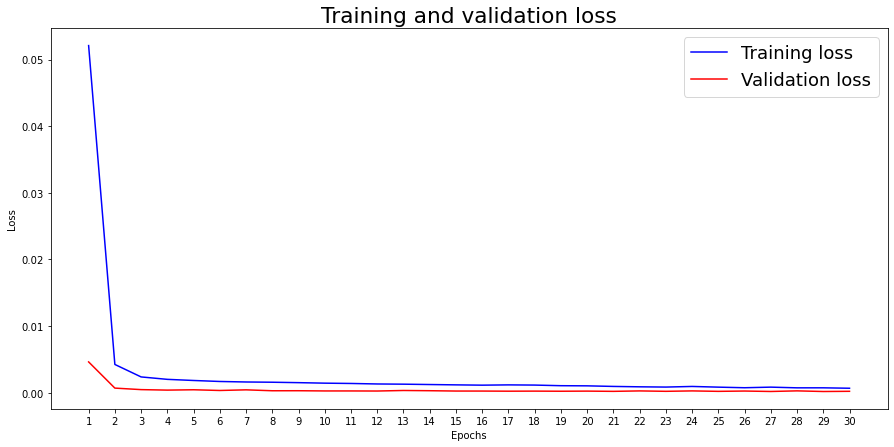

In [18]:
import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, 'b',color = 'blue', label='Training loss')
plt.plot(epochs, val_loss_values50, 'b',color='red', label='Validation loss')#验证损失
plt.rc('font', size = 18)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
#fig.savefig('img/validationlossconv1dlstm.png', dpi=300)
plt.show()

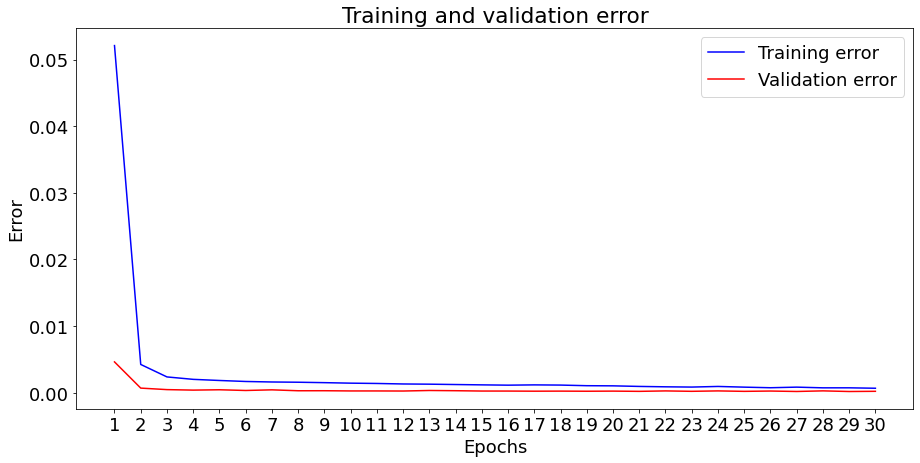

In [19]:
mse = history_dict['mse']
vmae = history_dict['val_mse']
epochs = range(1, len(mse) + 1)
plt.plot(epochs, mse, 'b',color = 'blue', label='Training error')
plt.plot(epochs, vmae, 'b',color='red', label='Validation error')
plt.title('Training and validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
#fig.savefig('img/validationlossconv1dlstm.png', dpi=300)
plt.show()

In [20]:
trainScore = model.evaluate(x_train, 
                            y_train, 
                            verbose=2)
testScore = model.evaluate(x_test, y_test, verbose=0)

In [21]:
#predicting values for y_test
p = model.predict(x_test)

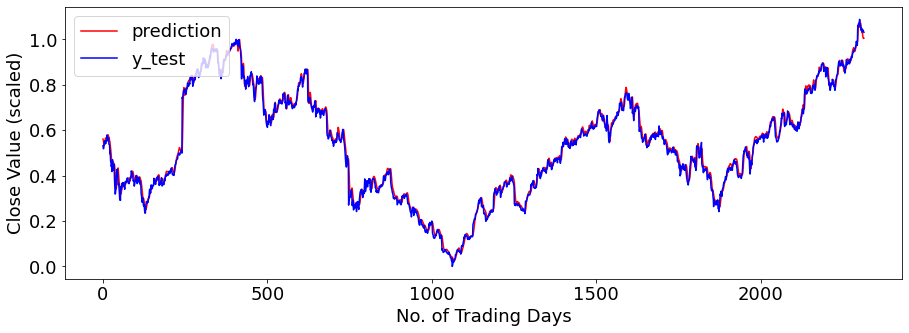

In [22]:
plt.plot(p,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.xlabel('No. of Trading Days')
plt.ylabel('Close Value (scaled)')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(15, 5)
#fig.savefig('img/25/mrftestconv1dlstm.png', dpi=300)
plt.show()